In [1]:
import cv2
import numpy as np


def readImagesAndTimes():
    times = np.array([1 / 30.0, 0.25, 2.5, 15.0], dtype=np.float32)

    filenames = ["d:\computervision\IMG_8253.jpg", "d:\computervision\IMG_8254.jpg", "d:\computervision\IMG_8255.jpg", "d:\computervision\IMG_8256.jpg"]

    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        images.append(im)

    return images, times

In [2]:
images, times = readImagesAndTimes()

Classifier mean accuracy:  100


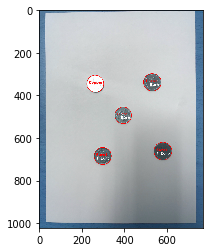

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import math
import numpy as np
import argparse
import glob
import cv2
image = cv2.imread('d:\computervision\IMG_8253.jpg')

# resize image while retaining aspect ratio
d = 1024 / image.shape[1]
dim = (1024, int(image.shape[0] * d))
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

# create a copy of the image to display results
output = image.copy()

# convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# improve contrast accounting for differences in lighting conditions:
# create a CLAHE object to apply contrast limiting adaptive histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)


def calcHistogram(img):
    # create mask
    m = np.zeros(img.shape[:2], dtype="uint8")
    (w, h) = (int(img.shape[1] / 2), int(img.shape[0] / 2))
    cv2.circle(m, (w, h), 60, 255, -1)

    # calcHist expects a list of images, color channels, mask, bins, ranges
    h = cv2.calcHist([img], [0, 1, 2], m, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    # return normalized "flattened" histogram
    return cv2.normalize(h, h).flatten()


def calcHistFromFile(file):
    img = cv2.imread(file)
    return calcHistogram(img)


# define Enum class
class Enum(tuple): __getattr__ = tuple.index


# Enumerate material types for use in classifier
Material = Enum(('Copper', 'Brass', 'Euro1', 'Euro2'))

# locate sample image files
sample_images_copper = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\copper\*")
sample_images_brass = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\brass\*")
sample_images_euro1 = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\euro1\*")
sample_images_euro2 = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\euro2\*")

# define training data and labels
X = []
y = []

# compute and store training data and labels
for i in sample_images_copper:
    X.append(calcHistFromFile(i))
    y.append(Material.Copper)
for i in sample_images_brass:
    X.append(calcHistFromFile(i))
    y.append(Material.Brass)
for i in sample_images_euro1:
    X.append(calcHistFromFile(i))
    y.append(Material.Euro1)
for i in sample_images_euro2:
    X.append(calcHistFromFile(i))
    y.append(Material.Euro2)

# instantiate classifier
# Multi-layer Perceptron
# score: 0.974137931034
clf = MLPClassifier(solver="lbfgs")

# split samples into training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2)

# train and score classifier
clf.fit(X_train, y_train)
score = int(clf.score(X_test, y_test) * 100)
print("Classifier mean accuracy: ", score)

# blur the image using Gaussian blurring, where pixels closer to the center
# contribute more "weight" to the average, first argument is the source image,
# second argument is kernel size, third one is sigma (0 for autodetect)
# we use a 7x7 kernel and let OpenCV detect sigma
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# circles: A vector that stores x, y, r for each detected circle.
# src_gray: Input image (grayscale)
# CV_HOUGH_GRADIENT: Defines the detection method.
# dp = 2.2: The inverse ratio of resolution
# min_dist = 100: Minimum distance between detected centers
# param_1 = 200: Upper threshold for the internal Canny edge detector
# param_2 = 100*: Threshold for center detection.
# min_radius = 50: Minimum radius to be detected.
# max_radius = 120: Maximum radius to be detected.
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100,
                           param1=200, param2=100, minRadius=50, maxRadius=120)


def predictMaterial(roi):
    # calculate feature vector for region of interest
    hist = calcHistogram(roi)

    # predict material type
    s = clf.predict([hist])

    # return predicted material type
    return Material[int(s)]


# todo: refactor
diameter = []
materials = []
coordinates = []

count = 0
if circles is not None:
    # append radius to list of diameters (we don't bother to multiply by 2)
    for (x, y, r) in circles[0, :]:
        diameter.append(r)

    # convert coordinates and radii to integers
    circles = np.round(circles[0, :]).astype("int")

    # loop over coordinates and radii of the circles
    for (x, y, d) in circles:
        count += 1

        # add coordinates to list
        coordinates.append((x, y))

        # extract region of interest
        roi = image[y - d:y + d, x - d:x + d]

        # try recognition of material type and add result to list
        material = predictMaterial(roi)
        materials.append(material)

        # write masked coin to file
        if False:
            m = np.zeros(roi.shape[:2], dtype="uint8")
            w = int(roi.shape[1] / 2)
            h = int(roi.shape[0] / 2)
            cv2.circle(m, (w, h), d, (255), -1)
            maskedCoin = cv2.bitwise_and(roi, roi, mask=m)
            cv2.imwrite("extracted/01coin{}.png".format(count), maskedCoin)

        # draw contour and results in the output image
        cv2.circle(output, (x, y), d, (255, 0, 0), 2)
        cv2.putText(output, material,
                    (x - 40, y), cv2.FONT_HERSHEY_PLAIN,
                    1.5, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

# get biggest diameter
biggest = max(diameter)
i = diameter.index(biggest)

# scale everything according to maximum diameter
# todo: this should be chosen by the user
if materials[i] == "Euro2":
    diameter = [x / biggest * 25.75 for x in diameter]
    scaledTo = "Scaled to 2 Euro"
elif materials[i] == "Brass":
    diameter = [x / biggest * 24.25 for x in diameter]
    scaledTo = "Scaled to 50 Cent"
elif materials[i] == "Euro1":
    diameter = [x / biggest * 23.25 for x in diameter]
    scaledTo = "Scaled to 1 Euro"
elif materials[i] == "Copper":
    diameter = [x / biggest * 21.25 for x in diameter]
    scaledTo = "Scaled to 5 Cent"
else:
    scaledTo = "unable to scale.."

i = 0
total = 0
while i < len(diameter):
    d = diameter[i]
    m = materials[i]
    (x, y) = coordinates[i]
    t = "Unknown"

    # compare to known diameters with some margin for error
    if math.isclose(d, 25.75, abs_tol=1.25) and m == "Euro2":
        t = "2 Euro"
        total += 200
    elif math.isclose(d, 23.25, abs_tol=2.5) and m == "Euro1":
        t = "1 Euro"
        total += 100
    elif math.isclose(d, 19.75, abs_tol=1.25) and m == "Brass":
        t = "10 Cent"
        total += 10
    elif math.isclose(d, 22.25, abs_tol=1.0) and m == "Brass":
        t = "20 Cent"
        total += 20
    elif math.isclose(d, 24.25, abs_tol=2.5) and m == "Brass":
        t = "50 Cent"
        total += 50
    elif math.isclose(d, 16.25, abs_tol=1.25) and m == "Copper":
        t = "1 Cent"
        total += 1
    elif math.isclose(d, 18.75, abs_tol=1.25) and m == "Copper":
        t = "2 Cent"
        total += 2
    elif math.isclose(d, 21.25, abs_tol=2.5) and m == "Copper":
        t = "5 Cent"
        total += 5

    # write result on output image
    cv2.putText(output, t,
                (x - 40, y + 22), cv2.FONT_HERSHEY_PLAIN,
                1.5, (255, 255, 255), thickness=2, lineType=cv2.LINE_AA)
    i += 1

# resize output image while retaining aspect ratio
d = 768 / output.shape[1]
dim = (768, int(output.shape[0] * d))
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
output = cv2.resize(output, dim, interpolation=cv2.INTER_AREA)


from skimage import transform,data
import matplotlib.pyplot as pl

pl.figure()
pl.imshow(output)
pl.show()

Classifier mean accuracy:  100


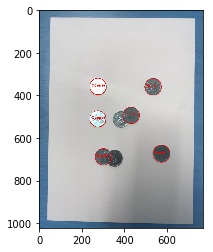

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import math
import numpy as np
import argparse
import glob
import cv2
image1 = cv2.imread('d:\computervision\IMG_8254.jpg')

# resize image while retaining aspect ratio
d = 1024 / image1.shape[1]
dim = (1024, int(image1.shape[0] * d))
image1 = cv2.resize(image1, dim, interpolation=cv2.INTER_AREA)

# create a copy of the image to display results
output1 = image1.copy()

# convert image to grayscale
gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# improve contrast accounting for differences in lighting conditions:
# create a CLAHE object to apply contrast limiting adaptive histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)


def calcHistogram(img):
    # create mask
    m = np.zeros(img.shape[:2], dtype="uint8")
    (w, h) = (int(img.shape[1] / 2), int(img.shape[0] / 2))
    cv2.circle(m, (w, h), 60, 255, -1)

    # calcHist expects a list of images, color channels, mask, bins, ranges
    h = cv2.calcHist([img], [0, 1, 2], m, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    # return normalized "flattened" histogram
    return cv2.normalize(h, h).flatten()


def calcHistFromFile(file):
    img = cv2.imread(file)
    return calcHistogram(img)


# define Enum class
class Enum(tuple): __getattr__ = tuple.index


# Enumerate material types for use in classifier
Material = Enum(('Copper', 'Brass', 'Euro1', 'Euro2'))

# locate sample image files
sample_images_copper = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\copper\*")
sample_images_brass = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\brass\*")
sample_images_euro1 = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\euro1\*")
sample_images_euro2 = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\euro2\*")

# define training data and labels
X = []
y = []

# compute and store training data and labels
for i in sample_images_copper:
    X.append(calcHistFromFile(i))
    y.append(Material.Copper)
for i in sample_images_brass:
    X.append(calcHistFromFile(i))
    y.append(Material.Brass)
for i in sample_images_euro1:
    X.append(calcHistFromFile(i))
    y.append(Material.Euro1)
for i in sample_images_euro2:
    X.append(calcHistFromFile(i))
    y.append(Material.Euro2)

# instantiate classifier
# Multi-layer Perceptron
# score: 0.974137931034
clf = MLPClassifier(solver="lbfgs")

# split samples into training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2)

# train and score classifier
clf.fit(X_train, y_train)
score = int(clf.score(X_test, y_test) * 100)
print("Classifier mean accuracy: ", score)

# blur the image using Gaussian blurring, where pixels closer to the center
# contribute more "weight" to the average, first argument is the source image,
# second argument is kernel size, third one is sigma (0 for autodetect)
# we use a 7x7 kernel and let OpenCV detect sigma
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# circles: A vector that stores x, y, r for each detected circle.
# src_gray: Input image (grayscale)
# CV_HOUGH_GRADIENT: Defines the detection method.
# dp = 2.2: The inverse ratio of resolution
# min_dist = 100: Minimum distance between detected centers
# param_1 = 200: Upper threshold for the internal Canny edge detector
# param_2 = 100*: Threshold for center detection.
# min_radius = 50: Minimum radius to be detected.
# max_radius = 120: Maximum radius to be detected.
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100,
                           param1=200, param2=100, minRadius=50, maxRadius=120)


def predictMaterial(roi):
    # calculate feature vector for region of interest
    hist = calcHistogram(roi)

    # predict material type
    s = clf.predict([hist])

    # return predicted material type
    return Material[int(s)]


# todo: refactor
diameter = []
materials = []
coordinates = []

count = 0
if circles is not None:
    # append radius to list of diameters (we don't bother to multiply by 2)
    for (x, y, r) in circles[0, :]:
        diameter.append(r)

    # convert coordinates and radii to integers
    circles = np.round(circles[0, :]).astype("int")

    # loop over coordinates and radii of the circles
    for (x, y, d) in circles:
        count += 1

        # add coordinates to list
        coordinates.append((x, y))

        # extract region of interest
        roi = image1[y - d:y + d, x - d:x + d]

        # try recognition of material type and add result to list
        material = predictMaterial(roi)
        materials.append(material)

        # write masked coin to file
        if False:
            m = np.zeros(roi.shape[:2], dtype="uint8")
            w = int(roi.shape[1] / 2)
            h = int(roi.shape[0] / 2)
            cv2.circle(m, (w, h), d, (255), -1)
            maskedCoin = cv2.bitwise_and(roi, roi, mask=m)
            cv2.imwrite("extracted/01coin{}.png".format(count), maskedCoin)

        # draw contour and results in the output image
        cv2.circle(output1, (x, y), d, (255, 0, 0), 2)
        cv2.putText(output1, material,
                    (x - 40, y), cv2.FONT_HERSHEY_PLAIN,
                    1.5, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

# get biggest diameter
biggest = max(diameter)
i = diameter.index(biggest)

# scale everything according to maximum diameter
# todo: this should be chosen by the user
if materials[i] == "Euro2":
    diameter = [x / biggest * 25.75 for x in diameter]
    scaledTo = "Scaled to 2 Euro"
elif materials[i] == "Brass":
    diameter = [x / biggest * 24.25 for x in diameter]
    scaledTo = "Scaled to 50 Cent"
elif materials[i] == "Euro1":
    diameter = [x / biggest * 23.25 for x in diameter]
    scaledTo = "Scaled to 1 Euro"
elif materials[i] == "Copper":
    diameter = [x / biggest * 21.25 for x in diameter]
    scaledTo = "Scaled to 5 Cent"
else:
    scaledTo = "unable to scale.."

i = 0
total = 0
while i < len(diameter):
    d = diameter[i]
    m = materials[i]
    (x, y) = coordinates[i]
    t = "Unknown"

    # compare to known diameters with some margin for error
    if math.isclose(d, 25.75, abs_tol=1.25) and m == "Euro2":
        t = "2 Euro"
        total += 200
    elif math.isclose(d, 23.25, abs_tol=2.5) and m == "Euro1":
        t = "1 Euro"
        total += 100
    elif math.isclose(d, 19.75, abs_tol=1.25) and m == "Brass":
        t = "10 Cent"
        total += 10
    elif math.isclose(d, 22.25, abs_tol=1.0) and m == "Brass":
        t = "20 Cent"
        total += 20
    elif math.isclose(d, 24.25, abs_tol=2.5) and m == "Brass":
        t = "50 Cent"
        total += 50
    elif math.isclose(d, 16.25, abs_tol=1.25) and m == "Copper":
        t = "1 Cent"
        total += 1
    elif math.isclose(d, 18.75, abs_tol=1.25) and m == "Copper":
        t = "2 Cent"
        total += 2
    elif math.isclose(d, 21.25, abs_tol=2.5) and m == "Copper":
        t = "5 Cent"
        total += 5

    # write result on output image
    cv2.putText(output, t,
                (x - 40, y + 22), cv2.FONT_HERSHEY_PLAIN,
                1.5, (255, 255, 255), thickness=2, lineType=cv2.LINE_AA)
    i += 1

# resize output image while retaining aspect ratio
d = 768 / output1.shape[1]
dim = (768, int(output1.shape[0] * d))
image1 = cv2.resize(image1, dim, interpolation=cv2.INTER_AREA)
output1 = cv2.resize(output1, dim, interpolation=cv2.INTER_AREA)


from skimage import transform,data
import matplotlib.pyplot as pl

pl.figure()
pl.imshow(output1)
pl.show()

Classifier mean accuracy:  100


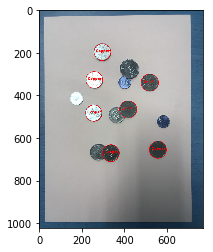

In [10]:
image1 = cv2.imread('d:\computervision\IMG_8255.jpg')

# resize image while retaining aspect ratio
d = 1024 / image1.shape[1]
dim = (1024, int(image1.shape[0] * d))
image1 = cv2.resize(image1, dim, interpolation=cv2.INTER_AREA)

# create a copy of the image to display results
output1 = image1.copy()

# convert image to grayscale
gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# improve contrast accounting for differences in lighting conditions:
# create a CLAHE object to apply contrast limiting adaptive histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)


def calcHistogram(img):
    # create mask
    m = np.zeros(img.shape[:2], dtype="uint8")
    (w, h) = (int(img.shape[1] / 2), int(img.shape[0] / 2))
    cv2.circle(m, (w, h), 60, 255, -1)

    # calcHist expects a list of images, color channels, mask, bins, ranges
    h = cv2.calcHist([img], [0, 1, 2], m, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    # return normalized "flattened" histogram
    return cv2.normalize(h, h).flatten()


def calcHistFromFile(file):
    img = cv2.imread(file)
    return calcHistogram(img)


# define Enum class
class Enum(tuple): __getattr__ = tuple.index


# Enumerate material types for use in classifier
Material = Enum(('Copper', 'Brass', 'Euro1', 'Euro2'))

# locate sample image files
sample_images_copper = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\copper\*")
sample_images_brass = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\brass\*")
sample_images_euro1 = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\euro1\*")
sample_images_euro2 = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\euro2\*")

# define training data and labels
X = []
y = []

# compute and store training data and labels
for i in sample_images_copper:
    X.append(calcHistFromFile(i))
    y.append(Material.Copper)
for i in sample_images_brass:
    X.append(calcHistFromFile(i))
    y.append(Material.Brass)
for i in sample_images_euro1:
    X.append(calcHistFromFile(i))
    y.append(Material.Euro1)
for i in sample_images_euro2:
    X.append(calcHistFromFile(i))
    y.append(Material.Euro2)

# instantiate classifier
# Multi-layer Perceptron
# score: 0.974137931034
clf = MLPClassifier(solver="lbfgs")

# split samples into training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2)

# train and score classifier
clf.fit(X_train, y_train)
score = int(clf.score(X_test, y_test) * 100)
print("Classifier mean accuracy: ", score)

# blur the image using Gaussian blurring, where pixels closer to the center
# contribute more "weight" to the average, first argument is the source image,
# second argument is kernel size, third one is sigma (0 for autodetect)
# we use a 7x7 kernel and let OpenCV detect sigma
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# circles: A vector that stores x, y, r for each detected circle.
# src_gray: Input image (grayscale)
# CV_HOUGH_GRADIENT: Defines the detection method.
# dp = 2.2: The inverse ratio of resolution
# min_dist = 100: Minimum distance between detected centers
# param_1 = 200: Upper threshold for the internal Canny edge detector
# param_2 = 100*: Threshold for center detection.
# min_radius = 50: Minimum radius to be detected.
# max_radius = 120: Maximum radius to be detected.
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100,
                           param1=200, param2=100, minRadius=50, maxRadius=120)


def predictMaterial(roi):
    # calculate feature vector for region of interest
    hist = calcHistogram(roi)

    # predict material type
    s = clf.predict([hist])

    # return predicted material type
    return Material[int(s)]


# todo: refactor
diameter = []
materials = []
coordinates = []

count = 0
if circles is not None:
    # append radius to list of diameters (we don't bother to multiply by 2)
    for (x, y, r) in circles[0, :]:
        diameter.append(r)

    # convert coordinates and radii to integers
    circles = np.round(circles[0, :]).astype("int")

    # loop over coordinates and radii of the circles
    for (x, y, d) in circles:
        count += 1

        # add coordinates to list
        coordinates.append((x, y))

        # extract region of interest
        roi = image1[y - d:y + d, x - d:x + d]

        # try recognition of material type and add result to list
        material = predictMaterial(roi)
        materials.append(material)

        # write masked coin to file
        if False:
            m = np.zeros(roi.shape[:2], dtype="uint8")
            w = int(roi.shape[1] / 2)
            h = int(roi.shape[0] / 2)
            cv2.circle(m, (w, h), d, (255), -1)
            maskedCoin = cv2.bitwise_and(roi, roi, mask=m)
            cv2.imwrite("extracted/01coin{}.png".format(count), maskedCoin)

        # draw contour and results in the output image
        cv2.circle(output1, (x, y), d, (255, 0, 0), 2)
        cv2.putText(output1, material,
                    (x - 40, y), cv2.FONT_HERSHEY_PLAIN,
                    1.5, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

# get biggest diameter
biggest = max(diameter)
i = diameter.index(biggest)

# scale everything according to maximum diameter
# todo: this should be chosen by the user
if materials[i] == "Euro2":
    diameter = [x / biggest * 25.75 for x in diameter]
    scaledTo = "Scaled to 2 Euro"
elif materials[i] == "Brass":
    diameter = [x / biggest * 24.25 for x in diameter]
    scaledTo = "Scaled to 50 Cent"
elif materials[i] == "Euro1":
    diameter = [x / biggest * 23.25 for x in diameter]
    scaledTo = "Scaled to 1 Euro"
elif materials[i] == "Copper":
    diameter = [x / biggest * 21.25 for x in diameter]
    scaledTo = "Scaled to 5 Cent"
else:
    scaledTo = "unable to scale.."

i = 0
total = 0
while i < len(diameter):
    d = diameter[i]
    m = materials[i]
    (x, y) = coordinates[i]
    t = "Unknown"

    # compare to known diameters with some margin for error
    if math.isclose(d, 25.75, abs_tol=1.25) and m == "Euro2":
        t = "2 Euro"
        total += 200
    elif math.isclose(d, 23.25, abs_tol=2.5) and m == "Euro1":
        t = "1 Euro"
        total += 100
    elif math.isclose(d, 19.75, abs_tol=1.25) and m == "Brass":
        t = "10 Cent"
        total += 10
    elif math.isclose(d, 22.25, abs_tol=1.0) and m == "Brass":
        t = "20 Cent"
        total += 20
    elif math.isclose(d, 24.25, abs_tol=2.5) and m == "Brass":
        t = "50 Cent"
        total += 50
    elif math.isclose(d, 16.25, abs_tol=1.25) and m == "Copper":
        t = "1 Cent"
        total += 1
    elif math.isclose(d, 18.75, abs_tol=1.25) and m == "Copper":
        t = "2 Cent"
        total += 2
    elif math.isclose(d, 21.25, abs_tol=2.5) and m == "Copper":
        t = "5 Cent"
        total += 5

    # write result on output image
    cv2.putText(output, t,
                (x - 40, y + 22), cv2.FONT_HERSHEY_PLAIN,
                1.5, (255, 255, 255), thickness=2, lineType=cv2.LINE_AA)
    i += 1

# resize output image while retaining aspect ratio
d = 768 / output1.shape[1]
dim = (768, int(output1.shape[0] * d))
image1 = cv2.resize(image1, dim, interpolation=cv2.INTER_AREA)
output1 = cv2.resize(output1, dim, interpolation=cv2.INTER_AREA)


from skimage import transform,data
import matplotlib.pyplot as pl

pl.figure()
pl.imshow(output1)
pl.show()

Classifier mean accuracy:  97


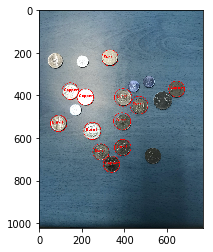

In [11]:
image1 = cv2.imread('d:\computervision\IMG_8256.jpg')

# resize image while retaining aspect ratio
d = 1024 / image1.shape[1]
dim = (1024, int(image1.shape[0] * d))
image1 = cv2.resize(image1, dim, interpolation=cv2.INTER_AREA)

# create a copy of the image to display results
output1 = image1.copy()

# convert image to grayscale
gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# improve contrast accounting for differences in lighting conditions:
# create a CLAHE object to apply contrast limiting adaptive histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)


def calcHistogram(img):
    # create mask
    m = np.zeros(img.shape[:2], dtype="uint8")
    (w, h) = (int(img.shape[1] / 2), int(img.shape[0] / 2))
    cv2.circle(m, (w, h), 60, 255, -1)

    # calcHist expects a list of images, color channels, mask, bins, ranges
    h = cv2.calcHist([img], [0, 1, 2], m, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    # return normalized "flattened" histogram
    return cv2.normalize(h, h).flatten()


def calcHistFromFile(file):
    img = cv2.imread(file)
    return calcHistogram(img)


# define Enum class
class Enum(tuple): __getattr__ = tuple.index


# Enumerate material types for use in classifier
Material = Enum(('Copper', 'Brass', 'Euro1', 'Euro2'))

# locate sample image files
sample_images_copper = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\copper\*")
sample_images_brass = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\brass\*")
sample_images_euro1 = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\euro1\*")
sample_images_euro2 = glob.glob("D:\mypyprojectwork\coin_detector-master\sample_images\euro2\*")

# define training data and labels
X = []
y = []

# compute and store training data and labels
for i in sample_images_copper:
    X.append(calcHistFromFile(i))
    y.append(Material.Copper)
for i in sample_images_brass:
    X.append(calcHistFromFile(i))
    y.append(Material.Brass)
for i in sample_images_euro1:
    X.append(calcHistFromFile(i))
    y.append(Material.Euro1)
for i in sample_images_euro2:
    X.append(calcHistFromFile(i))
    y.append(Material.Euro2)

# instantiate classifier
# Multi-layer Perceptron
# score: 0.974137931034
clf = MLPClassifier(solver="lbfgs")

# split samples into training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2)

# train and score classifier
clf.fit(X_train, y_train)
score = int(clf.score(X_test, y_test) * 100)
print("Classifier mean accuracy: ", score)

# blur the image using Gaussian blurring, where pixels closer to the center
# contribute more "weight" to the average, first argument is the source image,
# second argument is kernel size, third one is sigma (0 for autodetect)
# we use a 7x7 kernel and let OpenCV detect sigma
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# circles: A vector that stores x, y, r for each detected circle.
# src_gray: Input image (grayscale)
# CV_HOUGH_GRADIENT: Defines the detection method.
# dp = 2.2: The inverse ratio of resolution
# min_dist = 100: Minimum distance between detected centers
# param_1 = 200: Upper threshold for the internal Canny edge detector
# param_2 = 100*: Threshold for center detection.
# min_radius = 50: Minimum radius to be detected.
# max_radius = 120: Maximum radius to be detected.
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100,
                           param1=200, param2=100, minRadius=50, maxRadius=120)


def predictMaterial(roi):
    # calculate feature vector for region of interest
    hist = calcHistogram(roi)

    # predict material type
    s = clf.predict([hist])

    # return predicted material type
    return Material[int(s)]


# todo: refactor
diameter = []
materials = []
coordinates = []

count = 0
if circles is not None:
    # append radius to list of diameters (we don't bother to multiply by 2)
    for (x, y, r) in circles[0, :]:
        diameter.append(r)

    # convert coordinates and radii to integers
    circles = np.round(circles[0, :]).astype("int")

    # loop over coordinates and radii of the circles
    for (x, y, d) in circles:
        count += 1

        # add coordinates to list
        coordinates.append((x, y))

        # extract region of interest
        roi = image1[y - d:y + d, x - d:x + d]

        # try recognition of material type and add result to list
        material = predictMaterial(roi)
        materials.append(material)

        # write masked coin to file
        if False:
            m = np.zeros(roi.shape[:2], dtype="uint8")
            w = int(roi.shape[1] / 2)
            h = int(roi.shape[0] / 2)
            cv2.circle(m, (w, h), d, (255), -1)
            maskedCoin = cv2.bitwise_and(roi, roi, mask=m)
            cv2.imwrite("extracted/01coin{}.png".format(count), maskedCoin)

        # draw contour and results in the output image
        cv2.circle(output1, (x, y), d, (255, 0, 0), 2)
        cv2.putText(output1, material,
                    (x - 40, y), cv2.FONT_HERSHEY_PLAIN,
                    1.5, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

# get biggest diameter
biggest = max(diameter)
i = diameter.index(biggest)

# scale everything according to maximum diameter
# todo: this should be chosen by the user
if materials[i] == "Euro2":
    diameter = [x / biggest * 25.75 for x in diameter]
    scaledTo = "Scaled to 2 Euro"
elif materials[i] == "Brass":
    diameter = [x / biggest * 24.25 for x in diameter]
    scaledTo = "Scaled to 50 Cent"
elif materials[i] == "Euro1":
    diameter = [x / biggest * 23.25 for x in diameter]
    scaledTo = "Scaled to 1 Euro"
elif materials[i] == "Copper":
    diameter = [x / biggest * 21.25 for x in diameter]
    scaledTo = "Scaled to 5 Cent"
else:
    scaledTo = "unable to scale.."

i = 0
total = 0
while i < len(diameter):
    d = diameter[i]
    m = materials[i]
    (x, y) = coordinates[i]
    t = "Unknown"

    # compare to known diameters with some margin for error
    if math.isclose(d, 25.75, abs_tol=1.25) and m == "Euro2":
        t = "2 Euro"
        total += 200
    elif math.isclose(d, 23.25, abs_tol=2.5) and m == "Euro1":
        t = "1 Euro"
        total += 100
    elif math.isclose(d, 19.75, abs_tol=1.25) and m == "Brass":
        t = "10 Cent"
        total += 10
    elif math.isclose(d, 22.25, abs_tol=1.0) and m == "Brass":
        t = "20 Cent"
        total += 20
    elif math.isclose(d, 24.25, abs_tol=2.5) and m == "Brass":
        t = "50 Cent"
        total += 50
    elif math.isclose(d, 16.25, abs_tol=1.25) and m == "Copper":
        t = "1 Cent"
        total += 1
    elif math.isclose(d, 18.75, abs_tol=1.25) and m == "Copper":
        t = "2 Cent"
        total += 2
    elif math.isclose(d, 21.25, abs_tol=2.5) and m == "Copper":
        t = "5 Cent"
        total += 5

    # write result on output image
    cv2.putText(output, t,
                (x - 40, y + 22), cv2.FONT_HERSHEY_PLAIN,
                1.5, (255, 255, 255), thickness=2, lineType=cv2.LINE_AA)
    i += 1

# resize output image while retaining aspect ratio
d = 768 / output1.shape[1]
dim = (768, int(output1.shape[0] * d))
image1 = cv2.resize(image1, dim, interpolation=cv2.INTER_AREA)
output1 = cv2.resize(output1, dim, interpolation=cv2.INTER_AREA)


from skimage import transform,data
import matplotlib.pyplot as pl

pl.figure()
pl.imshow(output1)
pl.show()